### Build a simple econometric model and evaluate its preformance

Task: Take a simple econometric model and implement it. But the model is not the main thing here. What’s more important is the testing procedure step-by-step.
- What should we do to evaluate a simple algorithm that gives out buy and sell signal?
- What should we program and do to evaluate such an algotythm?
- What leverage should we use?
- Build it based on S&P500. And perhaps compare to other benchmarks.
- Take two or more models and compare them.
- Use the paper “INVESTMENT STRTEGIES THAT BEAT THE MARKET. WHAT CAN WE SQUEEZE FROM THE MARKET?”
- Describe results and provide visualizations.


###### 04.04.19

#### Data gathering

In [29]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
# First, downloading the data
ticker = '^GSPC'

# Setting time horizon of data
start_date = '2010-01-01'
end_date = '2019-04-04'

# Downloading the data using pandas_reader.data.DataReader
panel_data = data.DataReader(ticker, 'yahoo', start_date, end_date)

In [13]:
# Basic statistics for the downloaded data
panel_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2329.000000,2329.000000,2329.000000,2329.000000,2.329000e+03,2329.000000
mean,1889.747797,1870.972632,1880.714894,1881.160609,3.733736e+09,1881.160609
std,534.620409,532.229691,533.539543,533.353539,8.268849e+08,533.353539
min,1032.949951,1010.909973,1027.650024,1022.580017,1.025000e+09,1022.580017
25%,1363.459961,1348.339966,1358.040039,1357.989990,3.247710e+09,1357.989990
50%,1943.689941,1918.599976,1931.869995,1931.589966,3.612810e+09,1931.589966
75%,2251.689941,2233.620117,2241.129883,2241.350098,4.099600e+09,2241.350098
max,2940.909912,2927.110107,2936.760010,2930.750000,1.061781e+10,2930.750000


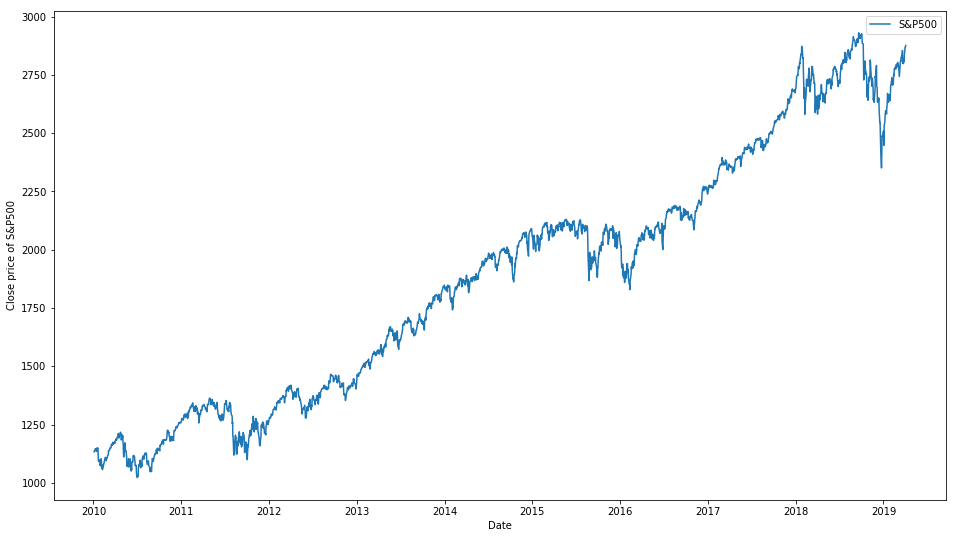

In [20]:
# Graph for data

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(panel_data.index, panel_data.Close, label='S&P500')

ax.set_xlabel('Date')
ax.set_ylabel('Close price of S&P500')
ax.legend()

#### Building a simple strategy

In [41]:
# At first let's go really simple and go with a "Golden Cross strategy"

'''
The Golden Cross is a bullish phenomenon when the 50-day moving average 
crosses above the 200-day moving average.

We'll also see the below crossing as a selling signal.

Yet we only need a signal generating sistem, so it will do.
'''

def GoldenCross(series, ma1, ma2):
    '''
    Takes the whole time series as a pandas dataframe, windows for 1st and 2nd simple MAs.
    Outputs pandas dataframe with addeed column for signals:
    +1 - for buy
    0  - no signal
    -1 - for sell
    Signals calculated based on "Close" column.
    '''
    series['ma1'] = series.Close.rolling(window=ma1).mean()
    series['ma2'] = series.Close.rolling(window=ma2).mean()

    conditions = [
    (pd.isna(series['ma1'])) | (pd.isna(series['ma2'])),
    (series['ma1'] >= series['ma2']),
    (series['ma1'] < series['ma2'])]
    choices = [0, 1, -1]
    
    series['signal'] = np.select(conditions, choices)
    
    return series
    

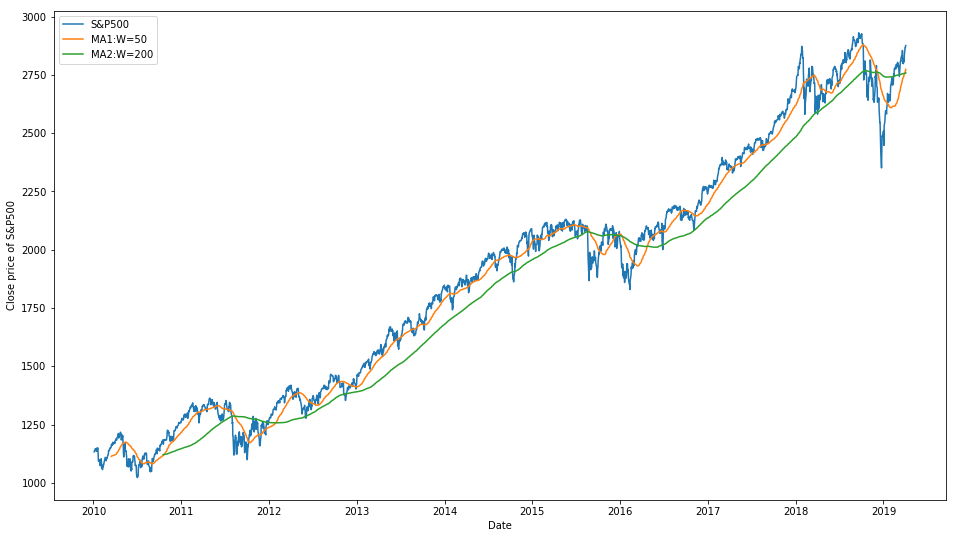

In [42]:
# Visualizintg the two MAs

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(panel_data.index, panel_data.Close, label='S&P500')
ax.plot(panel_data.index, panel_data.ma1, label='MA1:W=50')
ax.plot(panel_data.index, panel_data.ma2, label='MA2:W=200')

ax.set_xlabel('Date')
ax.set_ylabel('Close price of S&P500')
ax.legend()

In [47]:
# Watching statisstics for the signal created

panel_data.groupby('signal').count()

,High,Low,Open,Close,Volume,Adj Close,ma1,ma2
signal,,,,,,,,
-1,349,349,349,349,349,349,349,349
0,199,199,199,199,199,199,150,0
1,1781,1781,1781,1781,1781,1781,1781,1781


We now have a simple signal generated.

It's a signal for a long timeframe trading, as the MA values are relatively big. 

The signals are imbalaced towards buying signals in a relation of aproximately 5:1.

#### Model evaluation

Statistics to implement and calculate:
- aSD
- 5%-VaR
- maxFL
- MD
- AMD
- MLD
- Correlation
- AllRisk
- ARC
- Sharpe
- IR
- ARC/MD
- ARC/AMD

